<a href="https://colab.research.google.com/github/Sandhish/ML-Intern/blob/main/ML_Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load your dataset
# Make sure to update the path to your dataset
data = pd.read_csv('dataset.csv')

# Inspect the data
print(data.head())

# Define features and target variable
X = data.drop(columns=['CLTV'])  # Replace 'CLTV' with your target column name
y = data['CLTV']  # Replace 'CLTV' with your target column name

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.8, 1.0],
    'model__colsample_bytree': [0.5, 0.8, 1.0],
    'model__min_child_weight': [1, 2, 3]
}

n_iter = 50  # Number of iterations for RandomizedSearchCV

# Initialize and fit RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                        n_iter=n_iter, cv=3, random_state=42,
                                        scoring='neg_mean_squared_error')

random_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params = random_search_xgb.best_params_
print("Best parameters found:", best_params)

# Evaluate the model
y_pred = random_search_xgb.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate Relative RMSE
relative_rmse = (rmse / y_test.mean()) * 100  # Expressing RMSE as a percentage of the mean

# Print evaluation results
print("Mean Squared Error on Test Set:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Relative RMSE (%):", relative_rmse)
print("R-squared:", r2)


   CustomerID  Age  Gender  Location  AnnualIncome  PurchaseFrequency  \
0           1   59    Male  Suburban     110630.54               7.84   
1           2   51  Female  Suburban      38454.21               4.99   
2           3   34    Male     Rural      60455.88               5.60   
3           4   50  Female     Urban      89313.75               6.82   
4           5   22  Female  Suburban      59595.81               6.70   

   AverageOrderValue  TotalPurchases  CustomerTenure WebsiteEngagement  \
0             378.18              56               6            Medium   
1             173.80              87               6            Medium   
2             409.52              53               2              High   
3             129.10              97               1               Low   
4              21.55              25               6            Medium   

   CustomerServiceInteractions  MarketingSpend      CLTV  
0                            3         9899.24  39428.86 

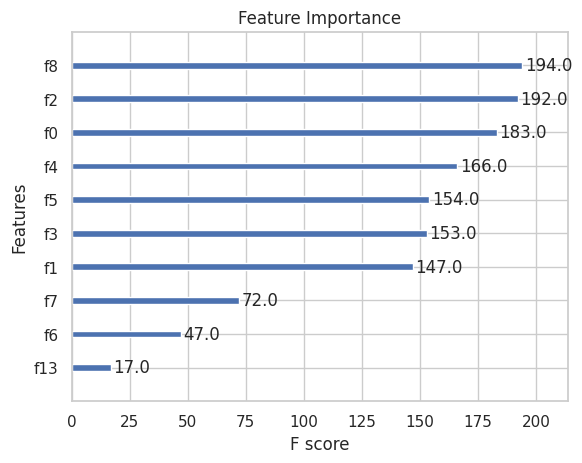

In [35]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Assuming you have performed Grid Search and stored the best estimator
best_model = random_search_xgb.best_estimator_.named_steps['model']  # Use 'grid_search' if that's your variable name
plot_importance(best_model, importance_type='weight', max_num_features=10, title='Feature Importance', xlabel='F score', ylabel='Features')

# Show the plot
plt.show()
